In [19]:
# Loading library
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import xgboost as xgb

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=45)

original_df = concrete_compressive_strength.data.original

In [15]:
original_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [4]:
print(original_df.shape)
print(pd.isna(original_df).sum().sum())

(303, 14)
6


# Preprocessing

In [5]:
df = original_df.copy()
df.loc[df[(df['num'] > 0)].index.tolist(),'num'] = 1

# Complete Case

In [ ]:
dropped_df = df.dropna()
dropped_df.shape

(297, 14)

In [ ]:
X = dropped_df.drop('num', axis=1)
y = dropped_df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 83.33%


d:\Anaconda\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


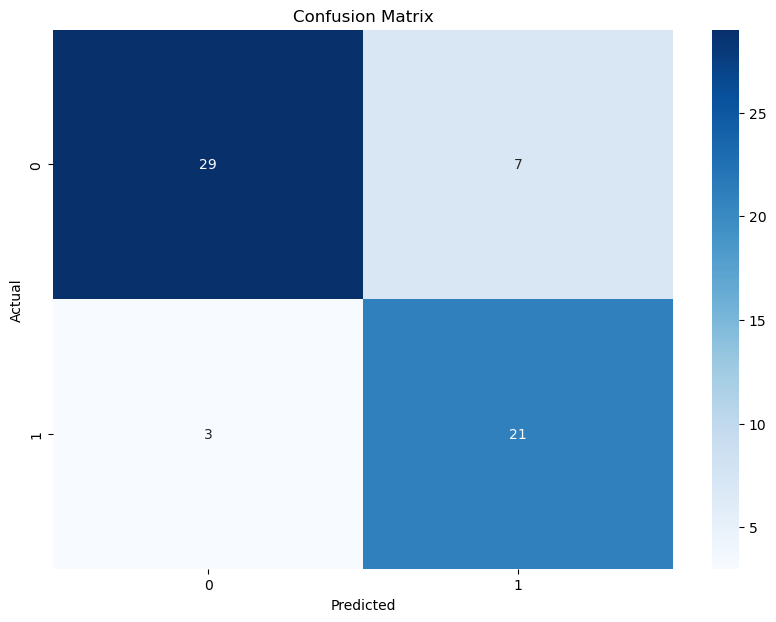

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generating Missing values (Implementation)

The percentage of missing values goes from 10% to 50%. And missing values of all 3 kinds (Missing Completely At Random/Missing At Random/Missing Not At Randoma) are mixed.

The way of creating missing values are described in the following subsections.

## Define MCAR

In [6]:
def generate_pair(length, width): # Input the length and width of the whole data frame
    return (np.random.randint(0, length), np.random.randint(0, width)) # generate a pair of numbers, which is the location of the missing entry

In [7]:
def insert_mcar(ratio, dataframe): # Input the percentage of mcar, and the data frame

    # Number of null values to insert
    num_nulls = int(ratio * (dataframe.size))

    temp_df = dataframe.copy()

    # Randomly choose positions to insert null values
    idx_pair = []

    for _ in range(num_nulls):
        
        p = generate_pair(temp_df.shape[0], temp_df.shape[1])
        while p in idx_pair: p = generate_pair(temp_df.shape[0], temp_df.shape[1])
        idx_pair.append(p)
        
        temp_df.iat[p[0], p[1]] = np.nan
    
    return temp_df#, pd.isna(temp_df)

## Special Missingness

In the following work, we will call both MAR and MNAR the 'special missingness', as they provide much more information than MCAR and have not been fully explored. Meanwhile, 'target variable' refers to the column we chose to place artificial missing. The choice of target variable is worth investigating. On one hand, if we are removing something significantly contribute to the prediction of the outcome, which might lead to poor performance of the model. On the other hand, slight difference could be found if a relatively unrelated variable is chosen to be the target varialbe.

## Define MAR

Suppose column 1 and 2 are selected for generating MAR, and we want to remove some values in column 1 based on the values appear on column 2. There are infinite way of creating missing values. Here we would exclude the output column 'num' from candidate variable as missingness in response variable will not be fed into the predictive model.

Notice that we are handling a data set with mixed type of features (Integer/Categorical, all in form of number), and thus the choice of variable to be based on is vital. 

In this case, we are introducing MAR in column based on 'quantile' of integer variables.

To be specific, say we need 6 percent data MAR of the whole data set, and if the value in column 'age' of an entry is smaller than 6th quantile of column 'age', then we remove the value in column 'trestbps'.

Since the distribution of categorical variable determines the percentage of missing values, which means that it could not be adjusted for experimental purpose, we are not using any categorical variable.

In [8]:
def insert_mar(ratio, dataframe): 
    
    """
    This function generates missing values in column 1 based on the values in column 2
    """
    
    temp_df = dataframe.copy()

    target_idx = temp_df['age'] < temp_df['age'].quantile(ratio)
    temp_df.iloc[target_idx, 4] = np.nan
    
    return temp_df#, pd.isna(temp_df)

## Define MNAR

Values in a certain column could be removed based on the values themselves. Similarly, if greater than 30 percentage of all the other values in this column, then turn them into null. Or, we can simply set up a known probability for creating missing values, and it is hidden from the downstream task model as the information the missingness of MNAR is depending on should remian unobservable. The way we creat missing values is straightforward, however, it could be much more complex in real world data set. Complicated or domain-specific design of generating missing values for investigation could be further developed to approximate the true situation.

In [9]:
def insert_mnar(ratio, dataframe, target_column): # Input the percentage of mnar, and the data frame


    temp_df = dataframe.copy()

    target_idx = temp_df[target_column] < temp_df[target_column].quantile(ratio)
    temp_df.iloc[target_idx, 4] = np.nan
    
    return temp_df#, pd.isna(temp_df)

In [10]:
def insert_null(dataframe, ratio_mcar, ratio_mar, ratio_mnar):

    # The order matters. Which one goes first?
    temp_df = insert_mar(ratio_mar, dataframe)
    temp_df = insert_mnar(ratio_mnar, temp_df, 'thalach')
    temp_df = insert_mcar(ratio_mcar, temp_df)

    return temp_df

## Inserting Null values

We specify the total missing ratio and manually split it into 3 parts. Notice that due to the unpredictivity of MCAR, the actual missing ratio may be slightly lower than the expected percentage as there might be overlap.

In [12]:
# total missing ratio = 0.1
ratio_mcar, ratio_mar, ratio_mnar = 1/30, 1/30, 1/30
missing_df = insert_null(df, ratio_mcar, ratio_mar, ratio_mnar)

In [13]:
print(pd.isna(missing_df).sum().sum())

166


# Imputation

We start with the feature with least missing entries. And use the feature as target, and others as predictors. This method follows a strategy that consider each variable with missing values as the outcome and utilize the other complete column (filled with by the mean of respective columns for continuous and most frequent data for categorical type of data)

In [14]:
missing_reg_df = missing_df.copy()
missing_reg_df_nan_count = missing_reg_df.isnull().sum()
missing_reg_df_nan_count # Find out which feature contains least missing values

age          8
sex          8
cp          12
trestbps    15
chol        30
fbs          6
restecg     16
thalach      7
exang       12
oldpeak      7
slope       12
ca          14
thal        11
num          8
dtype: int64

In [15]:
sort_index_li = np.argsort(missing_reg_df_nan_count).tolist()
sort_index_li

[5, 7, 9, 0, 1, 13, 12, 2, 8, 10, 11, 3, 6, 4]

In [16]:
for i in sort_index_li:

    temp_df = missing_reg_df
    # print(temp_df.head())
    target = temp_df.iloc[:, i] # Get the target column
    # print(temp_df.head())
    temp_df = temp_df.iloc[:, temp_df.columns != i] # Kick it out of the data frame
    # print(temp_df.head())
    temp_df_mean = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(temp_df) # Fill by respective mean

    # Select out the training set
    y_train = target[target.notnull()]
    x_train = temp_df_mean[y_train.index, :]

    # Select out the test set
    y_test = target[target.isnull()]
    x_test = temp_df_mean[y_test.index, :]

    model = RandomForestRegressor()
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)

    missing_reg_df.iloc[missing_reg_df.iloc[:, i].isnull(), i] = y_predict
    
    # print(missing_reg_df.head())

In [11]:
def impute(missing_df):
    
    missing_reg_df = missing_df.copy()
    missing_reg_df_nan_count = missing_reg_df.isnull().sum()

    sort_index_li = np.argsort(missing_reg_df_nan_count).tolist()

    for i in sort_index_li:

        temp_df = missing_reg_df
        # print(temp_df.head())
        target = temp_df.iloc[:, i] # Get the target column
        # print(temp_df.head())
        temp_df = temp_df.iloc[:, temp_df.columns != i] # Kick it out of the data frame
        # print(temp_df.head())
        temp_df_mean = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(temp_df) # Fill by respective mean

        # Select out the training set
        y_train = target[target.notnull()]
        x_train = temp_df_mean[y_train.index, :]

        # Select out the test set
        y_test = target[target.isnull()]
        x_test = temp_df_mean[y_test.index, :]

        model = RandomForestRegressor()
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)

        missing_reg_df.iloc[missing_reg_df.iloc[:, i].isnull(), i] = y_predict

    return missing_reg_df
    

In [ ]:
# diff_fill_li = [x_full, x_missing_zero, x_missing_mean_df, x_missing_reg_df]

# mse = []
# std = []

# for x in diff_fill_li:
#     model = RandomForestRegressor(random_state=0, n_estimators=100)
#     scores = cross_val_score(model, x, y_full, scoring='neg_mean_squared_error', cv=5).mean()
#     mse.append(scores * -1)

In [27]:
def evaluate_acc(df):
    X = df.drop('num', axis=1)
    y = df['num']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'Accuracy: {accuracy * 100:.2f}%, Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1: {f1 * 100:.2f}%')

    return y_test, y_pred, accuracy, precision, recall, f1

In [21]:
evaluate_acc(missing_reg_df)

Accuracy: 83.61%


In [13]:
def cm(y_test, y_pred):
    res = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(res, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

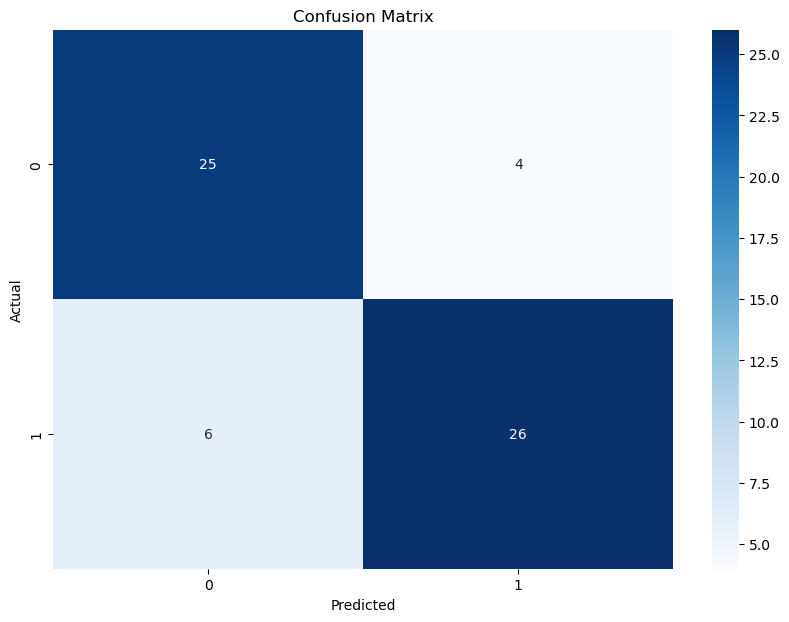

In [24]:
cm(y_test, y_pred)

# Experiment

In [14]:
def main(ratio_mcar, ratio_mar, ratio_mnar):
    
    # Create missing values first
    missing_df = insert_null(df, ratio_mcar, ratio_mar, ratio_mnar)

    # Impute the missing values based on Random Forest
    missing_reg_df = impute(missing_df)
    
    return missing_reg_df

In [30]:
np.array([1, 2]).mean()

1.5

In [37]:
def avg_eval(ratio_mcar, ratio_mar, ratio_mnar):
    # sum_acc, sum_prec, sum_rec, sum_f1 = 0, 0, 0, 0
    acc_li, prec_li, rec_li, f1_li = [], [], [], []
    for _ in range(10):
        temp_df = main(ratio_mcar, ratio_mar, ratio_mnar)
        y_test, y_pred, acc, prec, rec, f1 = evaluate_acc(temp_df)

        # Evaluate the performance of the predictive model after imputation
        acc_li.append(acc)
        prec_li.append(prec)
        rec_li.append(rec)
        f1_li.append(f1)

    # cm(y_test, y_pred)
    acc_li, prec_li, rec_li, f1_li = np.array(acc_li), np.array(prec_li), np.array(rec_li), np.array(f1_li)
    # print(f'Average Accuracy: {sum_acc * 10:.2f}%, Average Precision: {sum_prec * 10:.2f}%, Average Recall: {sum_rec * 10:.2f}%, Avgerage F1: {sum_f1 * 10:.2f}%')

    avg_acc = acc_li.mean() * 100
    avg_prec = prec_li.mean() * 100
    avg_rec = rec_li.mean() * 100
    avg_f1 = f1_li.mean() * 100

    print(f'Average Accuracy: {avg_acc :.2f}%, Average Precision: {avg_prec :.2f}%, Average Recall: {avg_rec:.2f}%, Avgerage F1: {avg_f1:.2f}%')

    return avg_acc, avg_prec, avg_rec, avg_f1

Accuracy: 81.97%, Precision: 83.87%, Recall: 81.25%, F1: 82.54%
Accuracy: 88.52%, Precision: 87.50%, Recall: 90.32%, F1: 88.89%
Accuracy: 85.25%, Precision: 84.38%, Recall: 87.10%, F1: 85.71%
Accuracy: 86.89%, Precision: 90.00%, Recall: 84.38%, F1: 87.10%
Accuracy: 86.89%, Precision: 87.10%, Recall: 87.10%, F1: 87.10%
Accuracy: 86.89%, Precision: 89.66%, Recall: 83.87%, F1: 86.67%
Accuracy: 86.89%, Precision: 92.86%, Recall: 81.25%, F1: 86.67%
Accuracy: 83.61%, Precision: 83.33%, Recall: 83.33%, F1: 83.33%
Accuracy: 78.69%, Precision: 80.65%, Recall: 78.12%, F1: 79.37%
Accuracy: 81.97%, Precision: 83.87%, Recall: 81.25%, F1: 82.54%


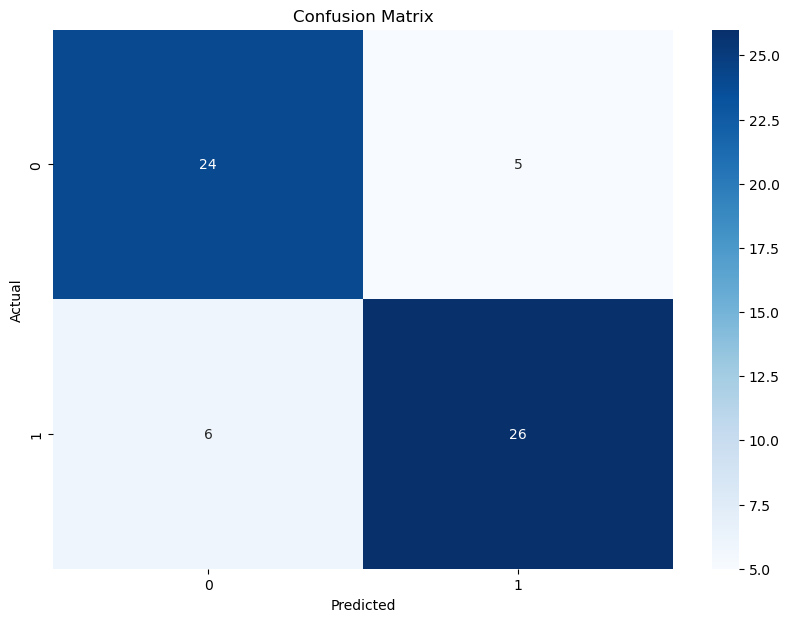

Average Accuracy: 84.75%, Average Precision: 86.32%, Average Recall: 86.32%, Avgerage F1: 86.32%


(84.75409836065573, 86.32045195720112, 86.32045195720112, 86.32045195720112)

In [36]:
avg_eval(1/30, 1/30, 1/30)

In [88]:
avg_acc_li, avg_prec_li, avg_rec_li, avg_f1_li = [], [], [], []
avg_acc, avg_prec, avg_rec, avg_f1 = avg_eval(1/30, 1/30, 1/30)

avg_acc_li.append(avg_acc)
avg_prec_li.append(avg_prec)
avg_rec_li.append(avg_rec)
avg_f1_li.append(avg_f1)

Accuracy: 81.97%, Precision: 81.82%, Recall: 84.38%, F1: 83.08%
Accuracy: 81.97%, Precision: 80.00%, Recall: 82.76%, F1: 81.36%
Accuracy: 83.61%, Precision: 86.21%, Recall: 80.65%, F1: 83.33%
Accuracy: 81.97%, Precision: 80.00%, Recall: 87.50%, F1: 83.58%
Accuracy: 77.05%, Precision: 76.67%, Recall: 76.67%, F1: 76.67%
Accuracy: 85.25%, Precision: 87.10%, Recall: 84.38%, F1: 85.71%
Accuracy: 81.97%, Precision: 86.21%, Recall: 78.12%, F1: 81.97%
Accuracy: 85.25%, Precision: 86.67%, Recall: 83.87%, F1: 85.25%
Accuracy: 88.52%, Precision: 90.32%, Recall: 87.50%, F1: 88.89%
Accuracy: 81.97%, Precision: 88.46%, Recall: 74.19%, F1: 80.70%
Average Accuracy: 82.95%, Average Precision: 84.34%, Average Recall: 84.34%, Avgerage F1: 84.34%


## Increasing MNAR from 1/15 while freezing MCAR and MAR

In [75]:
avg_acc, avg_prec, avg_rec, avg_f1 = avg_eval(1/30, 1/30, 1/15)
avg_acc_li.append(avg_acc)
avg_prec_li.append(avg_prec)
avg_rec_li.append(avg_rec)
avg_f1_li.append(avg_f1)

Accuracy: 85.25%, Precision: 89.29%, Recall: 80.65%, F1: 84.75%
Accuracy: 78.69%, Precision: 91.30%, Recall: 65.62%, F1: 76.36%
Accuracy: 81.97%, Precision: 78.12%, Recall: 86.21%, F1: 81.97%
Accuracy: 81.97%, Precision: 82.76%, Recall: 80.00%, F1: 81.36%
Accuracy: 86.89%, Precision: 87.10%, Recall: 87.10%, F1: 87.10%
Accuracy: 77.05%, Precision: 84.00%, Recall: 67.74%, F1: 75.00%
Accuracy: 88.52%, Precision: 90.32%, Recall: 87.50%, F1: 88.89%
Accuracy: 83.61%, Precision: 83.87%, Recall: 83.87%, F1: 83.87%
Accuracy: 80.33%, Precision: 85.19%, Recall: 74.19%, F1: 79.31%
Accuracy: 81.97%, Precision: 83.33%, Recall: 80.65%, F1: 81.97%
Average Accuracy: 82.62%, Average Precision: 85.53%, Average Recall: 85.53%, Avgerage F1: 85.53%


In [77]:
avg_acc, avg_prec, avg_rec, avg_f1 = avg_eval(1/30, 1/30, 1/10)
avg_acc_li.append(avg_acc)
avg_prec_li.append(avg_prec)
avg_rec_li.append(avg_rec)
avg_f1_li.append(avg_f1)

Accuracy: 85.25%, Precision: 89.29%, Recall: 80.65%, F1: 84.75%
Accuracy: 77.05%, Precision: 81.48%, Recall: 70.97%, F1: 75.86%
Accuracy: 77.05%, Precision: 76.67%, Recall: 76.67%, F1: 76.67%
Accuracy: 81.97%, Precision: 86.21%, Recall: 78.12%, F1: 81.97%
Accuracy: 83.61%, Precision: 85.71%, Recall: 80.00%, F1: 82.76%
Accuracy: 83.61%, Precision: 83.87%, Recall: 83.87%, F1: 83.87%
Accuracy: 86.89%, Precision: 89.66%, Recall: 83.87%, F1: 86.67%
Accuracy: 86.89%, Precision: 89.66%, Recall: 83.87%, F1: 86.67%
Accuracy: 80.33%, Precision: 85.71%, Recall: 75.00%, F1: 80.00%
Accuracy: 85.25%, Precision: 84.38%, Recall: 87.10%, F1: 85.71%
Average Accuracy: 82.79%, Average Precision: 85.26%, Average Recall: 85.26%, Avgerage F1: 85.26%


In [79]:
avg_acc, avg_prec, avg_rec, avg_f1 = avg_eval(1/30, 1/30, 1/5)
avg_acc_li.append(avg_acc)
avg_prec_li.append(avg_prec)
avg_rec_li.append(avg_rec)
avg_f1_li.append(avg_f1)

Accuracy: 81.97%, Precision: 83.87%, Recall: 81.25%, F1: 82.54%
Accuracy: 72.13%, Precision: 75.00%, Recall: 62.07%, F1: 67.92%
Accuracy: 83.61%, Precision: 82.35%, Recall: 87.50%, F1: 84.85%
Accuracy: 80.33%, Precision: 85.71%, Recall: 75.00%, F1: 80.00%
Accuracy: 80.33%, Precision: 78.12%, Recall: 83.33%, F1: 80.65%
Accuracy: 78.69%, Precision: 76.47%, Recall: 83.87%, F1: 80.00%
Accuracy: 90.16%, Precision: 90.00%, Recall: 90.00%, F1: 90.00%
Accuracy: 81.97%, Precision: 83.87%, Recall: 81.25%, F1: 82.54%
Accuracy: 77.05%, Precision: 77.42%, Recall: 77.42%, F1: 77.42%
Accuracy: 85.25%, Precision: 86.67%, Recall: 83.87%, F1: 85.25%
Average Accuracy: 81.15%, Average Precision: 81.95%, Average Recall: 81.95%, Avgerage F1: 81.95%


In [81]:
mnar_avg_acc_li = avg_acc_li
mnar_avg_prec_li = avg_prec_li
mnar_avg_rec_li = avg_rec_li
mnar_avg_f1_li = avg_f1_li

In [80]:
len(avg_acc_li)

4

## Increasing MCAR from 1/15 while freezing MNAR and MAR

In [84]:
avg_acc, avg_prec, avg_rec, avg_f1 = avg_eval(1/15, 1/30, 1/30)
avg_acc_li.append(avg_acc)
avg_prec_li.append(avg_prec)
avg_rec_li.append(avg_rec)
avg_f1_li.append(avg_f1)

Accuracy: 81.97%, Precision: 77.42%, Recall: 85.71%, F1: 81.36%
Accuracy: 78.69%, Precision: 79.31%, Recall: 76.67%, F1: 77.97%
Accuracy: 85.25%, Precision: 83.87%, Recall: 86.67%, F1: 85.25%
Accuracy: 80.33%, Precision: 83.33%, Recall: 78.12%, F1: 80.65%
Accuracy: 77.05%, Precision: 70.00%, Recall: 80.77%, F1: 75.00%
Accuracy: 80.33%, Precision: 81.25%, Recall: 81.25%, F1: 81.25%
Accuracy: 80.33%, Precision: 91.30%, Recall: 67.74%, F1: 77.78%
Accuracy: 78.69%, Precision: 77.42%, Recall: 80.00%, F1: 78.69%
Accuracy: 77.05%, Precision: 72.41%, Recall: 77.78%, F1: 75.00%
Accuracy: 78.69%, Precision: 82.14%, Recall: 74.19%, F1: 77.97%
Average Accuracy: 79.84%, Average Precision: 79.85%, Average Recall: 79.85%, Avgerage F1: 79.85%


In [85]:

avg_acc, avg_prec, avg_rec, avg_f1 = avg_eval(1/10, 1/30, 1/30)
avg_acc_li.append(avg_acc)
avg_prec_li.append(avg_prec)
avg_rec_li.append(avg_rec)
avg_f1_li.append(avg_f1)

Accuracy: 86.89%, Precision: 88.89%, Recall: 82.76%, F1: 85.71%
Accuracy: 83.61%, Precision: 75.86%, Recall: 88.00%, F1: 81.48%
Accuracy: 80.33%, Precision: 79.31%, Recall: 79.31%, F1: 79.31%
Accuracy: 77.05%, Precision: 84.00%, Recall: 67.74%, F1: 75.00%
Accuracy: 80.33%, Precision: 80.77%, Recall: 75.00%, F1: 77.78%
Accuracy: 78.69%, Precision: 84.00%, Recall: 70.00%, F1: 76.36%
Accuracy: 77.05%, Precision: 72.73%, Recall: 82.76%, F1: 77.42%
Accuracy: 80.33%, Precision: 85.19%, Recall: 74.19%, F1: 79.31%
Accuracy: 81.97%, Precision: 85.71%, Recall: 77.42%, F1: 81.36%
Accuracy: 72.13%, Precision: 70.37%, Recall: 67.86%, F1: 69.09%
Average Accuracy: 79.84%, Average Precision: 80.68%, Average Recall: 80.68%, Avgerage F1: 80.68%


In [86]:

avg_acc, avg_prec, avg_rec, avg_f1 = avg_eval(1/5, 1/30, 1/30)
avg_acc_li.append(avg_acc)
avg_prec_li.append(avg_prec)
avg_rec_li.append(avg_rec)
avg_f1_li.append(avg_f1)

Accuracy: 78.69%, Precision: 75.00%, Recall: 72.00%, F1: 73.47%
Accuracy: 81.97%, Precision: 76.92%, Recall: 80.00%, F1: 78.43%
Accuracy: 72.13%, Precision: 73.08%, Recall: 65.52%, F1: 69.09%
Accuracy: 62.30%, Precision: 56.00%, Recall: 53.85%, F1: 54.90%
Accuracy: 70.49%, Precision: 70.83%, Recall: 60.71%, F1: 65.38%
Accuracy: 65.57%, Precision: 56.52%, Recall: 54.17%, F1: 55.32%
Accuracy: 73.77%, Precision: 78.95%, Recall: 55.56%, F1: 65.22%
Accuracy: 70.49%, Precision: 72.22%, Recall: 50.00%, F1: 59.09%
Accuracy: 72.13%, Precision: 72.00%, Recall: 64.29%, F1: 67.92%
Accuracy: 68.85%, Precision: 62.50%, Recall: 74.07%, F1: 67.80%
Average Accuracy: 71.64%, Average Precision: 69.40%, Average Recall: 69.40%, Avgerage F1: 69.40%


In [87]:
mcar_avg_acc_li = avg_acc_li
mcar_avg_prec_li = avg_prec_li
mcar_avg_rec_li = avg_rec_li
mcar_avg_f1_li = avg_f1_li

## Increasing MAR from 1/15 while freezing MCAR and MNAR

In [89]:
avg_acc, avg_prec, avg_rec, avg_f1 = avg_eval(1/30, 1/15, 1/30) 
avg_acc_li.append(avg_acc)
avg_prec_li.append(avg_prec)
avg_rec_li.append(avg_rec)
avg_f1_li.append(avg_f1)

Accuracy: 75.41%, Precision: 75.86%, Recall: 73.33%, F1: 74.58%
Accuracy: 81.97%, Precision: 83.87%, Recall: 81.25%, F1: 82.54%
Accuracy: 91.80%, Precision: 90.91%, Recall: 93.75%, F1: 92.31%
Accuracy: 86.89%, Precision: 86.67%, Recall: 86.67%, F1: 86.67%
Accuracy: 88.52%, Precision: 87.88%, Recall: 90.62%, F1: 89.23%
Accuracy: 86.89%, Precision: 87.50%, Recall: 87.50%, F1: 87.50%
Accuracy: 83.61%, Precision: 86.21%, Recall: 80.65%, F1: 83.33%
Accuracy: 80.33%, Precision: 82.76%, Recall: 77.42%, F1: 80.00%
Accuracy: 78.69%, Precision: 79.31%, Recall: 76.67%, F1: 77.97%
Accuracy: 81.97%, Precision: 86.21%, Recall: 78.12%, F1: 81.97%
Average Accuracy: 83.61%, Average Precision: 84.72%, Average Recall: 84.72%, Avgerage F1: 84.72%


In [90]:

avg_acc, avg_prec, avg_rec, avg_f1 = avg_eval(1/30, 1/10, 1/30)
avg_acc_li.append(avg_acc)
avg_prec_li.append(avg_prec)
avg_rec_li.append(avg_rec)
avg_f1_li.append(avg_f1)

Accuracy: 85.25%, Precision: 86.67%, Recall: 83.87%, F1: 85.25%
Accuracy: 80.33%, Precision: 88.46%, Recall: 71.88%, F1: 79.31%
Accuracy: 80.33%, Precision: 83.33%, Recall: 78.12%, F1: 80.65%
Accuracy: 83.61%, Precision: 89.29%, Recall: 78.12%, F1: 83.33%
Accuracy: 88.52%, Precision: 87.50%, Recall: 90.32%, F1: 88.89%
Accuracy: 81.97%, Precision: 86.21%, Recall: 78.12%, F1: 81.97%
Accuracy: 80.33%, Precision: 82.14%, Recall: 76.67%, F1: 79.31%
Accuracy: 83.61%, Precision: 86.67%, Recall: 81.25%, F1: 83.87%
Accuracy: 77.05%, Precision: 81.48%, Recall: 70.97%, F1: 75.86%
Accuracy: 85.25%, Precision: 81.82%, Recall: 90.00%, F1: 85.71%
Average Accuracy: 82.62%, Average Precision: 85.36%, Average Recall: 85.36%, Avgerage F1: 85.36%


In [91]:

avg_acc, avg_prec, avg_rec, avg_f1 = avg_eval(1/30, 1/5, 1/30)
avg_acc_li.append(avg_acc)
avg_prec_li.append(avg_prec)
avg_rec_li.append(avg_rec)
avg_f1_li.append(avg_f1)

Accuracy: 80.33%, Precision: 82.76%, Recall: 77.42%, F1: 80.00%
Accuracy: 86.89%, Precision: 89.66%, Recall: 83.87%, F1: 86.67%
Accuracy: 81.97%, Precision: 81.82%, Recall: 84.38%, F1: 83.08%
Accuracy: 85.25%, Precision: 89.29%, Recall: 80.65%, F1: 84.75%
Accuracy: 86.89%, Precision: 89.66%, Recall: 83.87%, F1: 86.67%
Accuracy: 78.69%, Precision: 78.12%, Recall: 80.65%, F1: 79.37%
Accuracy: 80.33%, Precision: 82.76%, Recall: 77.42%, F1: 80.00%
Accuracy: 83.61%, Precision: 89.29%, Recall: 78.12%, F1: 83.33%
Accuracy: 81.97%, Precision: 83.33%, Recall: 80.65%, F1: 81.97%
Accuracy: 80.33%, Precision: 78.12%, Recall: 83.33%, F1: 80.65%
Average Accuracy: 82.62%, Average Precision: 84.48%, Average Recall: 84.48%, Avgerage F1: 84.48%


In [92]:
mar_avg_acc_li = avg_acc_li
mar_avg_prec_li = avg_prec_li
mar_avg_rec_li = avg_rec_li
mar_avg_f1_li = avg_f1_li

## Visualize the metrics

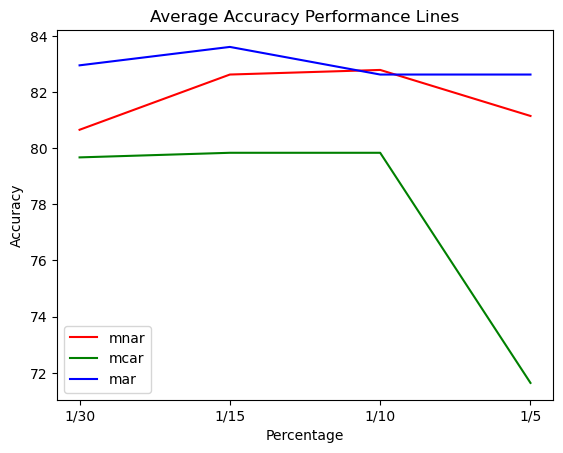

In [97]:
import matplotlib.pyplot as plt

# 横坐标
x = ['1/30', '1/15', '1/10', '1/5']

plt.plot(x, mnar_avg_acc_li, color='red', label='mnar')
plt.plot(x, mcar_avg_acc_li, color='green', label='mcar')
plt.plot(x, mar_avg_acc_li, color='blue', label='mar')

plt.xlabel('Percentage')
plt.ylabel('Accuracy')
plt.title('Average Accuracy Performance Lines')
plt.legend()
plt.show()


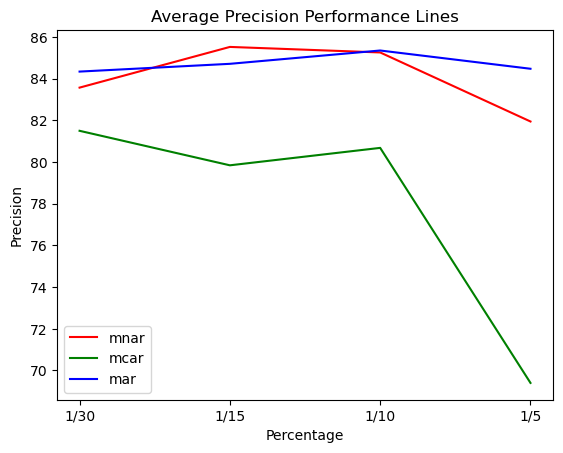

In [98]:
plt.plot(x, mnar_avg_prec_li, color='red', label='mnar')
plt.plot(x, mcar_avg_prec_li, color='green', label='mcar')
plt.plot(x, mar_avg_prec_li, color='blue', label='mar')

plt.xlabel('Percentage')
plt.ylabel('Precision')
plt.title('Average Precision Performance Lines')
plt.legend()
plt.show()

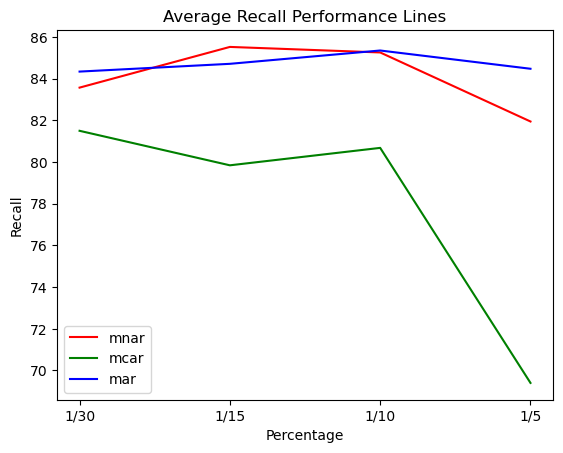

In [99]:
plt.plot(x, mnar_avg_rec_li, color='red', label='mnar')
plt.plot(x, mcar_avg_rec_li, color='green', label='mcar')
plt.plot(x, mar_avg_rec_li, color='blue', label='mar')

plt.xlabel('Percentage')
plt.ylabel('Recall')
plt.title('Average Recall Performance Lines')
plt.legend()
plt.show()

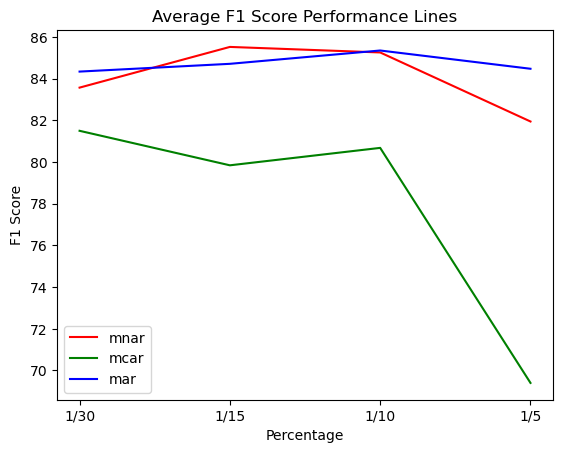

In [100]:
plt.plot(x, mnar_avg_f1_li, color='red', label='mnar')
plt.plot(x, mcar_avg_f1_li, color='green', label='mcar')
plt.plot(x, mar_avg_f1_li, color='blue', label='mar')

plt.xlabel('Percentage')
plt.ylabel('F1 Score')
plt.title('Average F1 Score Performance Lines')
plt.legend()
plt.show()